In [1]:
import cv2
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import open3d

In [19]:
def drawlines(img1, img2, lines, pts1, pts2):
    r, c = img1.shape
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
    for r, pt1, pt2 in zip(lines, pts1, pts2):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [c, -(r[2]+r[0]*c)/r[1]])
        img1 = cv2.line(img1, (x0, y0), (x1, y1), color, 1)
        img1 = cv2.circle(img1, tuple(pt1), 5, color, -1)
        img2 = cv2.circle(img2, tuple(pt2), 5, color, -1)
    return img1, img2

def draw_epipolar(img1, img2, F, pts1, pts2):
    lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1, 1, 2), 2, F)
    lines1 = lines1.reshape(-1, 3)
    img5, img6 = drawlines(img1, img2, lines1, pts1, pts2)

    lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1, 1, 2), 1, F)
    lines2 = lines2.reshape(-1, 3)
    img3, img4 = drawlines(img2, img1, lines2, pts2, pts1)

    plt.subplot(121)
    plt.imshow(img5)
    plt.subplot(122)
    plt.imshow(img3)
    plt.show()

def visualize_pcd(points_3d):
    """
    Visualize the point cloud.
    """
    # create a figure for 3D plotting
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # plot the 3D points
    ax.scatter(points_3d[0], points_3d[1], points_3d[2], c='r', marker='o', s=5)
    
    # set labels for the axes
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title("3D Point Cloud")
    
    # show the plot
    plt.show()

def visualize_point_cloud_with_open3d(points_3d):
    # convert points_3d to Open3D PointCloud format
    points = np.transpose(points_3d)  # Nx3 points array
    pcd = open3d.geometry.PointCloud()
    pcd.points = open3d.utility.Vector3dVector(points)
    
    # visualize the point cloud
    open3d.visualization.draw_geometries([pcd], window_name="3D Point Cloud")

In [3]:
def fit_projection(X, Y):    
    # build matrix A based on the correspondences
    A = []
    for i in range(X.shape[0]):
        x, y, z = X[i, 0], X[i, 1], X[i, 2]
        u, v = Y[i, 0], Y[i, 1]
        # equation for each correspondence
        A.append([x, y, z, 1, 0, 0, 0, 0, -u * x, -u * y, -u * z])
        A.append([0, 0, 0, 0, x, y, z, 1, -v * x, -v * y, -v * z])
        
    A = np.array(A)
    
    # solve Ah = 0 using SVD
    U, S, V = np.linalg.svd(A)
    
    # solution h is the smallest singular value of V
    h = V[-1, :]
    
    # build H matrix & normalization
    h = np.append(h, [1])
    H = h.reshape(3, 4)
    # H = H / H[2, 2]
    
    return H

In [22]:
"""
Q1: Camera Calibration
"""
points_2d = np.loadtxt("data/pts2d-norm-pic.txt")
print(points_2d.shape)
# b = np.append(points_2d, np.ones([points_2d.shape[0], 1], dtype=np.int32), axis=1)
# print(b.shape)

points_3d = np.loadtxt("data/pts3d-norm.txt")
print(points_3d.shape)
# A = np.append(points_3d, np.ones([points_3d.shape[0], 1], dtype=np.int32), axis=1)
# print(A.shape)

# P = A @ np.linalg.inv(A.T @ A) @ A.T
P = fit_projection(points_3d, points_2d)
print(P.shape)
print(f"\nP =\n{P}")

(20, 2)
(20, 3)
(3, 4)

P =
[[-2.16139798e-02 -1.99419043e-01  7.24945907e-01  7.02678089e-02]
 [-1.47733446e-02  6.40074852e-02 -2.53073904e-01 -7.28805413e-04]
 [ 2.58411448e-03 -2.38552804e-01  5.51366021e-01  1.00000000e+00]]


In [3]:
def normalize_points(points):
    # Normalize points so that the mean is 0 and the average distance to the origin is 1
    mean = np.mean(points, axis=0)
    dist = np.sqrt(np.mean(np.sum((points - mean)**2, axis=1)))
    scale = np.sqrt(2) / dist
    
    # Create normalization matrix
    T = np.array([[scale, 0, -scale*mean[0]],
                  [0, scale, -scale*mean[1]],
                  [0, 0, 1]])
    
    # Apply normalization matrix
    ones = np.ones((points.shape[0], 1))
    points_hom = np.hstack([points, ones])  # Convert to homogeneous coordinates
    normalized_points = (T @ points_hom.T).T
    
    return normalized_points[:, :2], T  # Return normalized points and the transformation matrix

def fit_fundamental(X, Y):
    # normalize points
    X, T_X = normalize_points(X)
    Y, T_Y = normalize_points(Y)
    
    # build matrix A based on the correspondences
    A = []
    for i in range(X.shape[0]):
        x, y = X[i, 0], X[i, 1]
        u, v = Y[i, 0], Y[i, 1]
        # equation for each correspondence
        A.append([x * u, x * v, x, y * u, y * v, y, u, v, 1])
    A = np.array(A)
    
    # solve Af = 0 using SVD
    U, S, V = np.linalg.svd(A)

    # build normalized fundamental matrix
    F_normalized = V[-1, :].reshape(3, 3)

    # enforce the rank-2 constraint by setting the smallest singular value to 0
    U, S, Vt = np.linalg.svd(F_normalized)
    S[2] = 0
    F_rank2 = U @ np.diag(S) @ Vt
    
    # denormalize the fundamental matrix by applying the inverse of the normalization matrices
    F = T_Y.T @ F_rank2 @ T_X

    # apply scaling normalization
    F /= F[2, 2]
    
    return F

NpzFile 'data/temple.npz' with keys: K1, K2, pts1, pts2
(110, 2)
(110, 2)
(640, 480)
(640, 480)
(3, 3)

F =
[[-1.90213021e-07  6.43692991e-06 -1.74540062e-03]
 [ 1.01351546e-05  2.35169599e-07  9.27190726e-02]
 [ 1.00421527e-04 -9.91702304e-02  1.00000000e+00]]


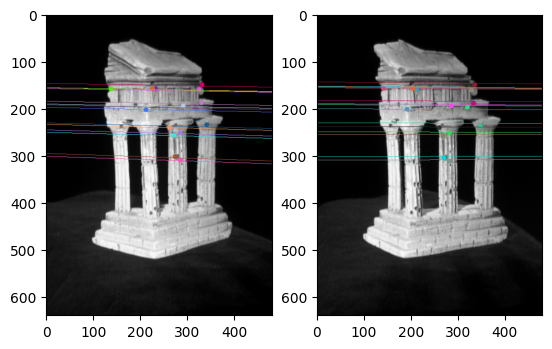

In [55]:
"""
Q2: Estimation of the Fundamental Matrix
"""
temple_npz = np.load("data/temple.npz")
print(temple_npz)

pts1 = temple_npz['pts1']
print(pts1.shape)
pts2 = temple_npz['pts2']
print(pts2.shape)

img1 = np.asarray(Image.open("data/im1.png").convert('L'))
img2 = np.asarray(Image.open("data/im2.png").convert('L'))
print(img1.shape)
print(img2.shape)

F = fit_fundamental(pts1, pts2)
print(F.shape)
print(f"\nF =\n{F}")

draw_epipolar(img1, img2, F, pts1[:15], pts2[:15])

In [4]:
def extract_essential(F, K1, K2):
    # E = K2^T * F * K1^-1
    return K2.T @ F @ np.linalg.inv(K1)

def calculate_projection_matrices(K1, K2, R, t):
    # P1 = K1 * [I | 0]
    P1 = K1 @ np.hstack((np.eye(3), np.zeros((3, 1))))
    
    # P2 = K2 * [R | t]
    P2 = K2 @ np.hstack((R, t.reshape(3, 1)))
    
    return P1, P2

def triangulate_points(P1, P2, pts1, pts2):
    # convert points to homogeneous coordinates (Nx3) by adding a column of ones
    # pts1_hom = np.hstack((pts1, np.ones((pts1.shape[0], 1))))
    # pts2_hom = np.hstack((pts2, np.ones((pts2.shape[0], 1))))
    
    # triangulate points using cv2.triangulatePoints
    points_4d = cv2.triangulatePoints(P1, P2, pts1.T, pts2.T)
    print(points_4d.shape)
    
    # convert from homogeneous to non-homogeneous coordinates (divide by the last coordinate)
    epsilon = 1e-10  # a small epsilon value to avoid division by zero
    points_3d = points_4d[:3] / (points_4d[3] + epsilon)
    # points_3d = cv2.convertPointsFromHomogeneous(points_4d.T)
    
    return points_3d

def count_positive_depth(points_3d, R, t):
    # check the depth of points (positive depth in both camera views)
    depth_camera_1 = points_3d[2, :]  # Z coordinates in the first camera
    depth_camera_2 = (R @ points_3d + t.reshape(3, 1))[2, :]  # Z coordinates in the second camera
    
    # count how many points have positive depth in both cameras
    positive_depth_count = np.sum((depth_camera_1 > 0) & (depth_camera_2 > 0))
    
    return positive_depth_count

In [20]:
"""
Q3: Triangulation
"""
# 3.1
temple_npz = np.load("data/temple.npz")
print(temple_npz)

K1 = temple_npz['K1']
K2 = temple_npz['K2']
print(K1.shape, K2.shape)

pts1, _ = normalize_points(temple_npz['pts1'])
pts2, _ = normalize_points(temple_npz['pts2'])
print(pts1.shape, pts2.shape)

# 3.2
F = cv2.findFundamentalMat(pts1, pts2)[0]
print(f"\nF =\n{F}")

E = extract_essential(F, K1, K2)
print(f"\nE =\n{E}")

# 3.3
R1, R2, t = cv2.decomposeEssentialMat(E)
poses = [[R1, t], [R1, -t], [R2, t], [R2, -t]]
R, t = poses[1]  # this pose has the highest positive depth count (57)

# 3.4
P1, P2 = calculate_projection_matrices(K1, K2, R, t)
print(f"\nP1 =\n{P1}")
print(f"\nP2 =\n{P2}\n")

# 3.5
points_3d = triangulate_points(P1, P2, pts1, pts2)
print(points_3d.shape)

depth_count = count_positive_depth(points_3d, R, t)
print(depth_count)

# 3.6
# visualize_pcd(points_3d)
visualize_point_cloud_with_open3d(points_3d)

(3, 3) (3, 3)
(110, 2) (110, 2)

F =
[[  1.03799909 -22.70011437   3.49454518]
 [ 27.768498    -1.17112061  -3.96320412]
 [ -6.63163724  -0.05314547   1.        ]]

E =
[[ 1.03799909e+00 -2.26182934e+01  1.05837760e+04]
 [ 2.78689497e+01 -1.17112061e+00 -1.41830870e+04]
 [ 4.71139019e+00 -4.68670778e+00 -1.88219195e+02]]

P1 =
[[1.5204e+03 0.0000e+00 3.0230e+02 0.0000e+00]
 [0.0000e+00 1.5259e+03 2.4690e+02 0.0000e+00]
 [0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00]]

P2 =
[[ 6.18350790e+02 -6.62762912e+02 -1.25753293e+03 -1.42306004e-02]
 [-8.32973510e+02  8.98469160e+02 -9.42464174e+02  2.31875569e-01]
 [ 7.02614732e-01  6.67447327e-01 -2.46671043e-01  9.68699686e-01]]

(4, 110)
(3, 110)
57
